In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import nltk
from datasets import load_dataset
import json

dataset = load_dataset("tner/ontonotes5")
ontonotes5_train_dataset = pd.DataFrame(dataset['train'])

# Read the JSON file
with open('dataset_label.json', 'r') as file:
    labels = json.load(file)

In [36]:
labels = { v:k for k,v in labels.items() }

training_tokens = []

for row in ontonotes5_train_dataset.iterrows():
    zipped = list(zip(row[1]['tokens'], row[1]['tags']))
    
    for item in zipped:
        training_tokens.append((item[0], labels[item[1]], nltk.pos_tag([item[0]])[0][1]))

# print(training_tokens[0:10])

In [37]:
df_ner_test = pd.read_csv('data/ner-test.tsv', delimiter='\t')

# adding POS tags
def pos_tagging(token):
    return nltk.pos_tag([token])[0][1]

df_ner_test['POS'] = df_ner_test['token'].apply(pos_tagging)
df_ner_test.head()

,sentence id,token id,token,BIO NER tag,POS
0,0,0,I,O,PRP
1,0,1,would,O,MD
2,0,2,n't,O,RB
3,0,3,be,O,VB
4,0,4,caught,O,NN


**Added the NLTK pos_tags to the test set because they are a useful feature for NERC.**

In [55]:
test_features = []
test_gold_labels = []

test_words = df_ner_test.iterrows()
for i, row in test_words:
    token: str = row['token']
    
    a_dict = {
        'word': token,                # the word itself
        'pos': row['POS'],                   # the part of speech
        'word[-3:]': token[-3:],      # the last three characters of the word
        'word[-2:]': token[-2:],      # the last two characters of the word
        'upper': token[0].isupper(),  # whether the first letter is uppercase
        'title': token.istitle(),      # whether the word is titlecased 
        'prev-word': "!NEWSENTENCE",    # Previous word.
        'prev-pos': "!NEWSENTENCE",     # Previous POS tag
        'prev-upper': "!NEWSENTENCE",   # Previous word is uppercase
        'prev-title': "!NEWSENTENCE",   # Previous word is titlecased
                                 
        # 'upper' and 'lower' will be slightly different because
        # of words like 'EU'
    }
    
    #If we have a previous word, add it to the features list to improve NERC
    if i > 0:
        # only get previous word if they're part of the same sentence
        prev_row = df_ner_test.iloc[i - 1]
        
        if prev_row['sentence id'] == row['sentence id']:
            a_dict['prev-word'] = prev_row['token']
            a_dict['prev-pos'] = prev_row['POS']
            a_dict['prev-upper'] = prev_row['token'][0].isupper()
            a_dict['prev-title'] = prev_row['token'].istitle()

    test_features.append(a_dict)
    test_gold_labels.append(row['BIO NER tag'])


In [56]:
training_features = []
training_gold_labels = []

for i, (token, ne_label, pos) in enumerate(training_tokens):
   if token == '' or token == 'DOCSTART':
      continue
   
   a_dict = {
      'word': token,                # the word itself
      'pos': pos,                   # the part of speech
      'word[-3:]': token[-3:],      # the last three characters of the word
      'word[-2:]': token[-2:],      # the last two characters of the word
      'upper': token[0].isupper(),  # whether the first letter is uppercase
      'title': token.istitle(),     # whether the word is titlecased 
      'prev-word': "!NEWSENTENCE",       # the previous word (!NEWSENTENCE if it's the first word)
      'prev-pos': "!NEWSENTENCE",        # the previous POS tag (!NEWSENTENCE if it's the first word)
      'prev-upper': "!NEWSENTENCE",      # whether the previous word is uppercase (!NEWSENTENCE if it's the first word)
      'prev-title': "!NEWSENTENCE"       # whether the previous word is titlecased (!NEWSENTENCE if it's the first word)
   }
   
   # If the sentence is not ending
   if i > 0:
      prev_token = training_tokens[i - 1][0]
      if prev_token != '.':
         a_dict['prev-word'] = prev_token
         a_dict['prev-pos'] = training_features[i-1]['pos']
         a_dict['prev-upper'] = prev_token[0].isupper()
         a_dict['prev-title'] = prev_token.istitle()
      

   training_features.append(a_dict)
   training_gold_labels.append(ne_label)

In [57]:
from collections import Counter
print('Count labels in the training set: ')
Counter(training_tokens[i][1] for i in range(len(training_tokens)))


Count labels in the training set: 


Counter({'O': 939111,
         'I-ORG': 18246,
         'B-PERSON': 15429,
         'B-GPE': 15405,
         'I-DATE': 13333,
         'B-ORG': 12820,
         'I-PERSON': 11147,
         'B-DATE': 10922,
         'B-CARDINAL': 7355,
         'B-NORP': 6870,
         'I-MONEY': 4912,
         'I-GPE': 3679,
         'I-PERCENT': 2498,
         'B-MONEY': 2411,
         'I-WORK_OF_ART': 2400,
         'I-CARDINAL': 2289,
         'B-PERCENT': 1763,
         'B-ORDINAL': 1640,
         'I-EVENT': 1605,
         'B-LOC': 1514,
         'I-TIME': 1507,
         'I-FAC': 1467,
         'I-LOC': 1395,
         'I-QUANTITY': 1235,
         'B-TIME': 1233,
         'B-WORK_OF_ART': 974,
         'B-FAC': 860,
         'I-LAW': 785,
         'B-EVENT': 748,
         'B-QUANTITY': 657,
         'B-PRODUCT': 606,
         'I-PRODUCT': 576,
         'I-NORP': 446,
         'B-LANGUAGE': 304,
         'B-LAW': 282,
         'I-LANGUAGE': 13,
         'I-ORDINAL': 5})

In [58]:
print('Count labels in the test set: ')
Counter(df_ner_test['BIO NER tag'])

Count labels in the test set: 


Counter({'O': 160,
         'I-WORK_OF_ART': 9,
         'B-PERSON': 6,
         'I-ORG': 6,
         'B-WORK_OF_ART': 4,
         'B-ORG': 3,
         'I-PERSON': 3,
         'B-DATE': 1,
         'I-DATE': 1})

In [59]:
# count nans in training_features
print("NaNs IN TRAINING FEATURES")
for key in training_features[0].keys():
    print(key, sum(1 for i in training_features if i[key] is None))

print("\nNaNs IN TEST FEATURES")
for key in test_features[0].keys():
    print(key, sum(1 for i in test_features if i[key] is None))

NaNs IN TRAINING FEATURES
word 0
pos 0
word[-3:] 0
word[-2:] 0
upper 0
title 0
prev-word 0
prev-pos 0
prev-upper 0
prev-title 0

NaNs IN TEST FEATURES
word 0
pos 0
word[-3:] 0
word[-2:] 0
upper 0
title 0
prev-word 0
prev-pos 0
prev-upper 0
prev-title 0


In [60]:
# SHORT TRAINING DATA FOR DEBUGGING
active = False # Set to True to make SVM sonic the hedgehog but also terrible

def debugging(features, labels, active):
    if active:
        return features[:5000], labels[:5000]
    else:
        return features, labels

training_features, training_gold_labels = debugging(training_features, training_gold_labels, active)
len(training_features), len(test_features)

(1088442, 193)

In [61]:
from sklearn.feature_extraction import DictVectorizer

# Concat all features
all_features = training_features.copy()
all_features.extend(test_features)

vec = DictVectorizer()
the_array = vec.fit_transform(all_features)
print(the_array.shape)

vec_training_features = the_array[:len(training_features)]
vec_test_features = the_array[len(training_features):]

print(vec_training_features.shape, vec_test_features.shape)

(1088635, 89878)
(1088442, 89878) (193, 89878)


**NEW SVM WITH PSEUDO-EMBEDDINGS**

In [62]:
from sklearn import svm
lin_clf = svm.LinearSVC()
from sklearn.metrics import classification_report

lin_clf.fit(vec_training_features, training_gold_labels)
predicted = lin_clf.predict(vec_test_features)

unique_labels = np.unique(['O', 'I-WORK_OF_ART', 'B-WORK_OF_ART', 'B-DATE', 'I-DATE', 'B-PERSON', 'I-PERSON', 'I-ORG', 'B-ORG']) #Labels that exist in the test set
report = classification_report(test_gold_labels, predicted, labels=unique_labels)

print(report)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


               precision    recall  f1-score   support

       B-DATE       1.00      1.00      1.00         1
        B-ORG       1.00      0.67      0.80         3
     B-PERSON       1.00      1.00      1.00         6
B-WORK_OF_ART       1.00      0.25      0.40         4
       I-DATE       0.50      1.00      0.67         1
        I-ORG       0.50      0.17      0.25         6
     I-PERSON       1.00      0.67      0.80         3
I-WORK_OF_ART       0.00      0.00      0.00         9
            O       0.92      0.99      0.96       160

    micro avg       0.92      0.90      0.91       193
    macro avg       0.77      0.64      0.65       193
 weighted avg       0.87      0.90      0.87       193



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_pr

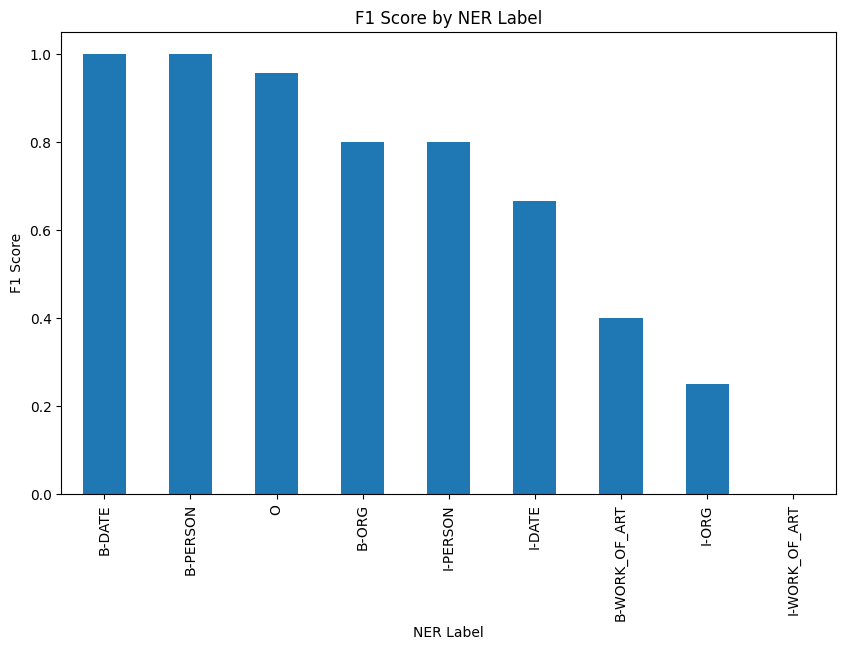

In [63]:
report_dict = classification_report(test_gold_labels, predicted, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.sort_values(by='f1-score', ascending=False)
report_df.drop('accuracy', inplace=True)
report_df.drop('macro avg', inplace=True)
report_df.drop('weighted avg', inplace=True)
report_df.drop('B-CARDINAL', inplace=True)
report_df.drop('B-GPE', inplace=True)
report_df.drop('I-EVENT', inplace=True)
report_df.drop('I-GPE', inplace=True)
report_df['f1-score'].plot(kind='bar', figsize=(10, 6))
plt.ylabel('F1 Score')
plt.xlabel('NER Label')
plt.title('F1 Score by NER Label')
plt.show()